# Improved Logistic Regression to battle Imbalance Data: Test/Train Sets and SMOTE 

Prevoisly, we explored logistic regression for Credit loan default. A usecase that is very widely used in the financial industry to predict how likely a client is to default on their loan.

The dataset used was from University of Irvine Machine Learning Repository. https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

It contains the amount of money loaned to clients, sex, age, marital status, education, billing and payment history for the 6 months. We will be using the same dataset for this investigation as well.

The trouble that exits with this dataset is the split of people who defaulted(28%) on their loan and those who did not (72%). This is called class imbalance, which limits the accuracy of learning in our model.

The goal of this investigation is to refine the prevous logistic regression model. Meaning, use a corrolation matrix to choose feautures that carry the most weight in predicting Default, and introduce a method to battle class imbalance. This investigation aims to uncover the the effect of Test/Train sets and SMOTE in imbalance datasets. We will learn if the model learns better after implementing these. 



## Logestic Regression

### Loading the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

### Load and clean the data

We skip one row to avoid using x1, x2 ,x3.... instead of the header names. 

In [2]:
df = pd.read_csv("cdp.csv", skiprows = 1)
df.rename(columns={"default payment next month": "DEFAULT"}, inplace=True)
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

### Correlation Exploration and Correlation Matrix
A correlarion matrix helps us understand the relationship between features so that we can work with those that carry most weight in predicting default.

Here we used seaborn and matplotlib to create this. We need to ensure that we are only using numerical values here. 

Text(0.5, 1.0, 'Correlation matrix of numeric features')

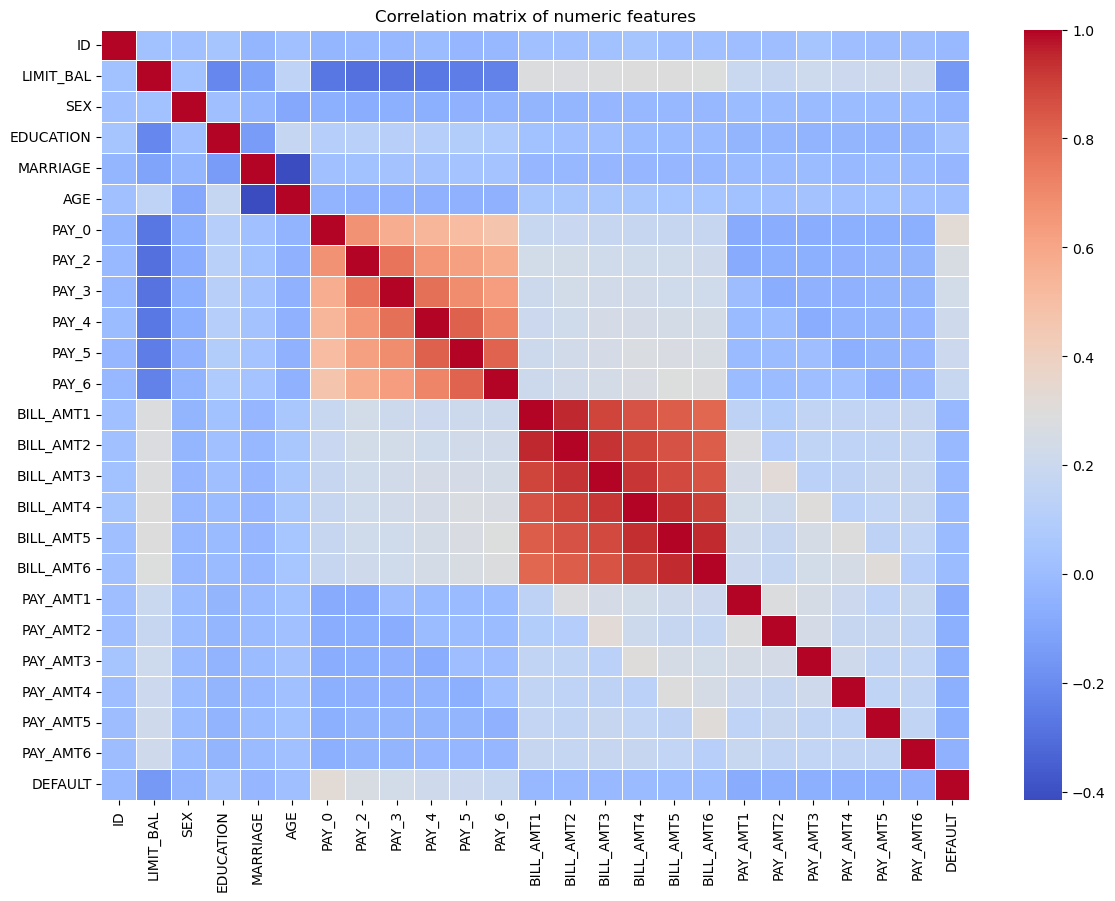

In [3]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()
plt.figure(figsize=(14,10))

sns.heatmap(
    corr,
    annot=False,
    cmap='coolwarm',
    linewidths = 0.5
)

plt.title("Correlation matrix of numeric features")

Based on the correlation matrix above, we conclude that PAY_0 to PAY_6 have the heighest correlation with our DEFAULT value. Meaning they would be best to use for our algorithm to learn

### Preparing data for training
Making sure that the entire default column is in numeric form and picking out X vector.

Since we had trouble with class imbalance last time, this time we are going to create train test splits so that the model prevents leakage and helps us battle imbalance when paired with SMOTE (will be introduced later)

We define what features are being used to learn and what feature is being predicted. 

We will also import the train_test_split package from the sklearn.model_selection Library.
This is the package we will use to set up and split our data into Feauture train/test and prediction train/test.


In [33]:
from sklearn.model_selection import train_test_split

credit_data = df.copy()
credit_data["DEFAULT"] = credit_data["DEFAULT"].astype(int)

X = credit_data[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].values
y = credit_data["DEFAULT"].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify = y, random_state=42
)

#print("Training shape:", X_train.shape)
#print("Test shape:", X_test.shape)
#print("Default rate in Training:", y_train.mean())
#print("Training Test:", y_test.mean())



### *Scaling The Features
Since we are not using Limit_Balance, there is no need for scaling our feature in order for it to be have somewhat of an equal weight.

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



### Synthetic Minority Over-Sampleing Technique: SMOTE

In many real-life datasets, imbalances tend to exist. One of the ways of dealing this this is using SMOTE. SMOTE is an algorithm that identifies the minority instances, finds the neatest neighbour for each minority sample and generates Synthetic sample that would help the dataset imbalances. In our case the amount of people who have defaulted on their loan, is a minority subset of the dataset with only about 28% of data points indicating credit default.
We will use SMOTE library to perfom this operation.

We first load the SMOTE Pakcage from imblearn librabry. Then created a SMOTE object and applied it to our training data.


In [35]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train,y_train)

print("Before SMOTE: ",X_train, y_train)
print("After SMOTE: ",X_train_smote, y_train_smote)


Before SMOTE:  [[ 2  2  3  2  0  0]
 [ 1 -1 -1 -2 -2 -2]
 [ 1  2  0  0  0  0]
 ...
 [ 0  0  0  0  0  0]
 [ 1 -2 -1 -1 -1 -2]
 [-1 -1 -1 -1 -2 -2]] [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
After SMOTE:  [[ 2  2  3  2  0  0]
 [ 1 -1 -1 -2 -2 -2]
 [ 1  2  0  0  0  0]
 ...
 [ 2  2  2  2  2  0]
 [ 2  0  0  0  0  0]
 [-1 -1 -2 -2 -2 -2]] [0 0 0 ... 1 1 1]


###  Intercept column

Since we are building this algorithm from scratch, we must add the intercept column. The reason for adding this is for our model to be able to perform at its best mathematically. For context: 

$y = \sigma( \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n $

where $\beta_0$ is the intercept 
It represents model's prediction when all features are 0. Without it the model is forced to pass through (0,0,...,0) which never really is the case with real-world data. 

Now, we get the number of rows in the training set(Allows us to create a coloumn of 1s on the same length).The we add our column of 1s. Our feauture matrix is now complete. 

In [36]:
m_train = X_train_smote.shape[0]
X_train_smote = np.hstack([np.ones((m_train,1)),X_train_smote])
m_test = X_test.shape[0]
X_test = np.hstack([np.ones((m_test,1)),X_test])

### Defining Sigmoids Function

$ \sigma(z) = \frac{1}{1 + e^{-z}}$

We define a function that takes a z value and runs it through the sigmoid function.

In [37]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

### Defining the cost function

$
J(\beta) 
= -\frac{1}{m} \sum_{i=1}^m 
\left[
y^{(i)} \log(h_\beta(x^{(i)})) + 
(1 - y^{(i)}) \log(1 - h_\beta(x^{(i)}))
\right]
 $

 Likewise here, we have a cost_compute function that takes in values of X, y, and beta and runs it through our cost function defiened above.
 To get a better understanding of how our model is learning, we can compute and compare cost seperatly for the training vs. testing set. 
 

In [1]:
def compute_cost_weighted(X, y, beta, alpha=3.0):
    m = len(y)
    y = y.reshape(-1,1)
    preds = sigmoid(X @ beta)
    eps = 1e-15
    
    cost = -(1/m) * np.sum(
        alpha * y * np.log(preds + eps) +
        (1 - y) * np.log(1 - preds + eps)
    )
    return cost


### Implementing Gradient Decent
$\beta := \beta - \alpha \cdot \nabla_\beta J(\beta)
$

$\beta := \beta - \alpha \cdot \frac{1}{m} X^\top \left( h_\beta(X) - y \right)
$

In [39]:
def gradient_decent(X, y, beta, alpha, iterations):
  m = len(y)
  y = y.reshape(-1, 1)
  cost_history = np.zeros(iterations)


  for i in range(iterations):
    predictions = sigmoid(X @ beta)
    gradient = (1/m) * (X.T @ (predictions - y))
    beta = beta - alpha * gradient
    cost_history[i] = compute_cost(X, y, beta)

  return beta, cost_history

### Initilizing and Trining the model

Here we set our learning rate, number of itterations and call our gradient decent algorithm. 

In [40]:
beta = np.zeros((X_train_smote.shape[1],1))
alpha = 0.1
iterations = 5000

beta_final, cost_history = gradient_decent(X_train_smote,y_train_smote,beta, alpha,iterations)


### Cost Plot vs Itteration
We use Matplotlib to plot the cost vs. itterations graph. This shows how cost is minizing as the number of itterations increases. 

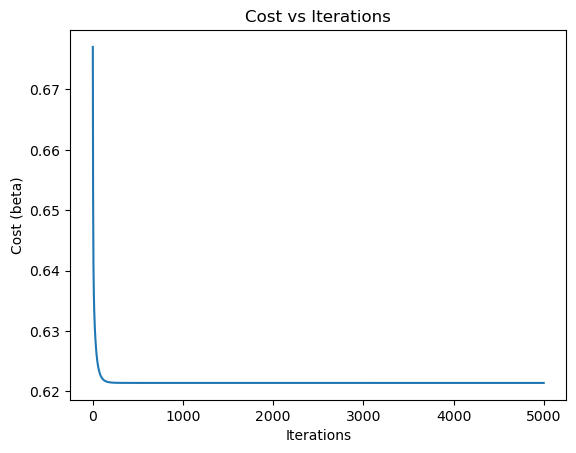

In [41]:
plt.plot(cost_history)
plt.title("Cost vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Cost (beta)")
plt.show()

### Evaluation

In this section we will use Sklearn librabry to calculate important Evaluation metric. The following code was learned from sklearn's website. It contains all of the functions needed. https://scikit-learn.org/stable/api/sklearn.metrics.html

I would like to introduce these metrics very breifly to build undersntading and intuidtion regarding this model. 

#### Accuracy 
The ratio between number of correct predictions and total number of predictions. Not a good metric in an imbalanced dataset like this. In this case the model is split 72% and 28%. If the model predicts 0 every time, it will achied a 72% accuracy. Not a good representation of precision.

#### Percision 
Percision Measures how many of the posetive predictions made by the model are actually correct. 

#### Recall
This is the models "Sensitivity". It measures how many of the actual posetive cases were correctly identified. 

#### F1 Score

Essentially mean of percision and recall. Important when we need a balance between percision and recall as it combines the two into a single number. 

In [49]:

from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

y_prob = sigmoid(X_test @ beta_final)

thresh = np.linspace(0.05,0.95,100)
f1_scores = []

for t in thresh: 
    y_pred_t = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    f1_scores.append(f1)

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

best_threshold, best_f1


y_pred_opt = (y_prob >= best_threshold).astype(int)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_opt))
print("Accuracy :", accuracy_score(y_test, y_pred_opt))
print("Precision:", precision_score(y_test, y_pred_opt))
print("Recall   :", recall_score(y_test, y_pred_opt))
print("F1       :", f1_score(y_test, y_pred_opt))


Confusion matrix:
 [[4641   32]
 [1238   89]]
Accuracy : 0.7883333333333333
Precision: 0.7355371900826446
Recall   : 0.06706857573474001
F1       : 0.12292817679558012


In the last lab we achieved an 82% accuracy. In this one only a 76%. However, the old lab was predicting most cases as 0s and not actually learning. In this case where the model is learning correctly, we see that accuracy is 76% and only 47% of the times the model has made correct posetive prediction. This is an OK model, but not statiscally sound enough for real-world deployment and usecases. 

### ROC Curve 

The Recieving Operating Characteristic(ROC)curve helps us understand this regression model more than the simple accuracy metric. It allows us to see and understand how well the model distingueshes between two classes which in this case are:

- People who default (1)
- People who did not default (0)

The Logestic Regression's output is a measure of probability, our model most be able to decide at which threshold someone is predicted to default or not default. In this particular investigation we have chosen 0.5 as the cut off. Poeple predicted more will be classified as likely to default, likewise, people under 0.5 will be classified as likely to not default on their loan. 

Meaning behinf X and Y axis: 

X --> False Posetive Rate (FPR)
Tells us how good the model is at people who actually defaulted 

Y --> True Posetive Rate (TPR)
Tells us how ofter the model flags someone incorectly as a possoble defaulting risk

<function matplotlib.pyplot.show(close=None, block=None)>

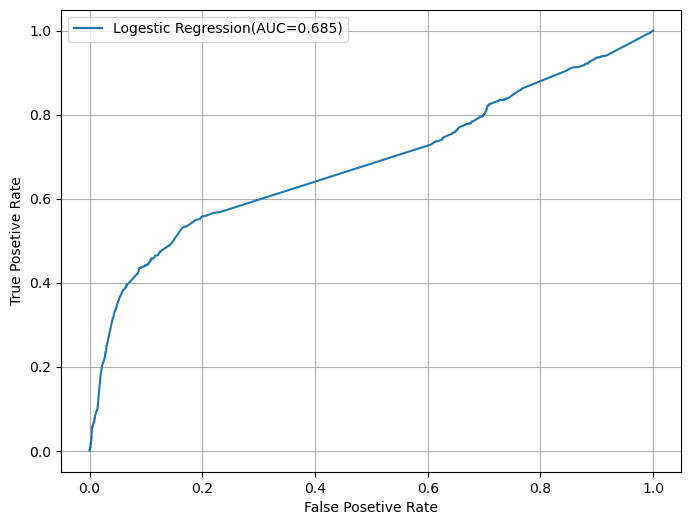

In [22]:
fpr,tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob )

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label= f"Logestic Regression(AUC={auc_score:.3f})")
plt.xlabel("False Posetive Rate")
plt.ylabel("True Posetive Rate")
plt.legend()
plt.grid(True)
plt.show


### Conclusion

In this investigation, we refined our existing logestic regression model with methods to battle sample imbalance. Since our data was 72% non-default and 28% default, this would be considered a highly imbalance dataset which is very common in the real world datasets. we used SMOTE to oversample the monority calss and give the model a fair chance to learn patters from both classes. After, we trained the data and achieved a 76.8% accuracy and 47.8% percision. Although, the accuracy is lowwer than our first model but our percision and recall score is higher. Meaning, after applying train/test sets and SMOTE function we were able to make the model more trust worthy. However, this model is by no means even remotely close to intudsty baselines.